# Dynamic Dish Based Restaurant Banking

### Problem Statement

- Current restaurant ranking in Yelp doesnt include dish of our choice. 
- What is the use of visiting the best ranked restaurants if you can’t get YOUR CHOICE OF DISH served the BEST on any DAY.
- Built a ML model to learn ranking of restaurants for any given dish name on a particular day/week/month.
***

### Effort
- Scraping internet (60%)
    - Yelp review, author info (184 restaurants, 75K reviews) scraped near Santa Clara, CA
- Modeling (30%)
    - feature set identification 
    - GBRegressor (R2_score = 0.95)
- Results/Analysis (10%)
    - Plots showing dish based restaurant ranking
***

### Machine Learning Based Ranking
#### Training Set Preparation
- Feature generation

|  1       | 2    |     3        |    4             |5                  |
|----------|------|--------------|------------------|-------------------|
|Dish Count|Rating|Date of Review|users Review Count|users Friend Count |



- Target – Dish based restaurant Ranking from past reviews
    - Used deterministic decay fn to decay contribution from old reviews = $$1-\exp\big({\frac{-1}{\alpha*date}}\big)$$  
    - Ranking Score for a restaurant (Dish) = $$\displaystyle\sum_{i=1}^{allPastReviews}{{({reviewRating_{i}}/_5)}\ *\ {\sqrt{dishCount_{i}}\ *\ decay\_func(rev\_Date_{i})}}$$

- Translated a ranking problem into a regression model where for a given pair of {dish X restaurant}, a affinity score is learnt.
- Trained using 10-20 popular menu items, over 8 years
***
### Future Improvements

- Extend the ranking system to handle multiple dish names.
- Currently I scraped 180 restaurants, collecting 75K reviews spanning 8 years.
    - It took nearly an hour to two to collect the data and had to handle DoS
    - Planning to use the publicily released (Aug 2018) Yelp Research Data set 
- Create webapp    

In [1]:
import pandas as pd
import string
from lxml import html
import requests
# encoding=utf8
import sys
reload(sys)
sys.setdefaultencoding('utf8')
import os
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import glob
from StringIO import StringIO 
import seaborn as sns
%matplotlib inline

In [244]:
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
#from sklearn.cross_validation import train_test_split
#from sklearn.model_selection import train_test_split
from sklearn.cross_validation import LeaveOneOut
#from sklearn.model_selection import LeaveOneOut
#from mlxtend.regressor import StackingRegressor
#https://tomaugspurger.github.io/scalable-ml-02
from sklearn.neural_network import MLPRegressor
import pickle

In [24]:
#sgd = SGDRegressor()
#slr.fit(X, y)
#sgd.partial_fit?

In [3]:
#df1=pd.read_csv('new_Restaurants/1_*.csv')
#fname = ''.join(glob.glob("new_Restaurants/" + "1_*.csv"))
#df1
#df1=pd.read_csv(fname)
#df1

In [15]:
#load already generated restaurant link
df1=pd.read_csv('All_Ind_Rest_SC3.csv')
del df1['Unnamed: 0']
#df1.columns=['indx','review_cnt','review_link']
df2=df1.copy()
df2['review_link']=df2['review_link'].apply(lambda x: x.split('?')[0])
df2['rest_name']=df2['review_link'].apply(lambda x: x.split('?')[0].split('/')[-1])

a=df2['rest_cnt'].values.tolist()
c=df2['rest_name'].values.tolist()

df_list=[]

#load individual restaurant scraped reviews into df and then append their pointers to a list to be concat and store later
for indx,rname in zip(a,c):
    fname = ''.join(glob.glob("new_Restaurants/" + str(indx) + "_" + rname + ".csv"))
    df_rest = pd.read_csv(fname)
    df_rest.review = df_rest.review.str.lower()
    del df_rest['Unnamed: 0']
    df_rest['rest_name']=rname
    df_list.append(df_rest)

In [3]:
#concat individual reviews for each restaurants into one file - All_Reviews.csv
#big_dataframe = pd.concat(df_list, ignore_index=True)
#big_dataframe.to_csv('All_Reviews.csv')

#Download All_Reviews.csv from 'https://drive.google.com/open?id=1ctLXFIWJi-r5fyd7FCyi0zlDGfaeRziM'
big_dataframe = pd.read_csv('./All_Reviews.csv')

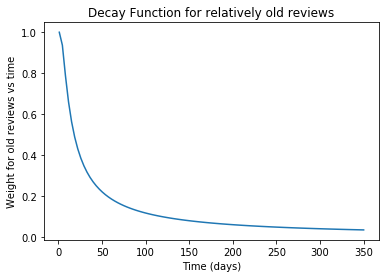

In [4]:
#search the number of occurence of the dish name in a review and take the sqrt function.
def calc_dish_cnt(str1):
    global dish_name
    return np.sqrt(str1.count(dish_name))

#hyperparameter
alpha=0.08

#decay old reviews
def decay_fn(date_diff):
    #return 1
    return float(1-np.exp(-1/(alpha*date_diff)))


x=np.linspace(1,350,100)
plt.title("Decay Function for relatively old reviews")
plt.xlabel('Time (days)')
plt.ylabel('Weight for old reviews vs time')
plt.plot(x,map(decay_fn,x))
#decay_fn(30)
plt.show()

In [6]:
#Extract dish count for each reviews
#big_dataframe['dcount']=big_dataframe.review.apply(calc_dish_cnt)
#tot_dish_cnt = big_dataframe.dcount.sum()

In [5]:

def sqrt_fcnt(x):
    if x.dcount>0:
        return np.sqrt(x.friendcnt)
    else:
        return 0
def sqrt_rcnt(x):
    if x.dcount>0:
        return np.sqrt(x.revcnt)
    else:
        return 0

def calc_tdidf1(x):
    if x.rating == 1 or x.rating == 2:
        return 0.0
    else:
        return float(x.dcount)*(float(x.rating)/5.0)

def calc_tdidf(x):
    global set_curr_time
    if x.rating == 1 or x.rating == 2:
        return 0.0
    else:
        date_elapsed = (set_curr_time - datetime.strptime(x.date, "%Y-%m-%d")).days + 0.001
        if date_elapsed < 0:
            return 0
        else:
            return float(x.dcount)*(float(x.rating)/5.0)*decay_fn(date_elapsed)


In [6]:
#populate the df with dish count, and corresponding friends count, rev count.
def init_df(df,en_time,dname):
    global dish_name, set_curr_time
    dish_name=dname
    
    df1=df.copy()
    df1['dcount']=df1.review.apply(calc_dish_cnt)
    
    df1['sqrt_fcnt']=df1.apply(sqrt_fcnt,axis=1)
    df1['sqrt_rcnt']=df1.apply(sqrt_rcnt,axis=1)
    #calc_tdidf1 (doesnt decay) is diff from calc_tdidf (has decay fn). tdidf1 = sqrt(dcount)*rating/5.0
    df1['tdidf1']=df1.apply(calc_tdidf1,axis=1)
    
    #set current time so that tdidf (with decay fn) is calculuated at this time by decaying all the past review weights
    set_curr_time=datetime.strptime(en_time, "%Y-%m-%d")
    df1['tdidf']=df1.apply(calc_tdidf,axis=1)
    
    return df1

def create_y(df,st_date,en_date):
    
    #st_date='2010-01-01'
    #en_date='2018-01-30'
    mask=(df['date'] > st_date) & (df['date'] <= en_date)
    df1 = df.loc[mask].copy()

    
    df2=df1.groupby('rest_name').sum().copy()

    #think if we should normalize the tdidf or not. Donot normalize now.
    #df2.tdidf=df2.tdidf.apply(lambda x: x/df2.tdidf.max())
    #ranking at the end of 2/28/18 for vada pav
    y=df2[['tdidf']]
    
    #y may not have all restaurants due to the groupby on the masked data set. Hence create yy with all rest and copy tdidf from y into it.
    yy=df.groupby('rest_name').sum()[['tdidf']].copy()

    #Initialize yy with all restaurants and their tdidf=0.0, then copy the tdidf for rest in y into yy, and finally
    #copy yy back to y. This step is needed so that we maintain the complete restaurant list, as the regression algo needs
    #complete match in the row numbers. When you do groupby on a subset of dates (df2), some restaurants with no values tend to
    #get filtered, we donot want this to happen. Instead we want to assign tdidf=0.0 for those filtered rest and retain them.
    yy[:]=0

    for i in range(yy.index.size):
        rname = yy.index[i]
        if rname in y.index:
            yy.loc[rname].tdidf=y.loc[rname].tdidf 
    yy.columns=['tdidf']   
    y=yy
    
    return y

#### Training Set Preparation
- Feature generation (X) for 6 months in the past

|                 |  feature-1                |feature-2          |feature-3          |  feature-1              |...|
|-----------------|---------------------------|:-----------------:|:-----------------:|:------------------------|:-:|
|                 |  **1st month**            |**1st month**      |**1st month**      |  **2nd month**          |...|
|**Restaurant Name-1**|Dish Count*(Rating / 5)|users Review Count |users Friend Count |Dish Count * (Rating / 5)|...|
|**Restaurant Name-2**|Dish Count*(Rating / 5)|users Review Count |users Friend Count |Dish Count * (Rating / 5)|...|
|      .          |           .               |        .          |         .         |           .             |...|
|      .          |           .               |        .          |         .         |           .             |...|
|      .          |           .               |        .          |         .         |           .             |...|
***
- Target – Dish based restaurant Ranking (y) from past reviews 
    - Ranking Score for a restaurant (Dish) = $$\displaystyle\sum_{i=1}^{allPastReviews}{{({reviewRating_{i}}/_5)}\ *\ {\sqrt{dishCount_{i}}\ *\ decay\_func(rev\_Date_{i})}}$$
    
|                     | ** y (Ranking score)** |
|---------------------|------------------------|
|**Restaurant Name-1**|$$\displaystyle\sum_{i=1}^{allPastReviews}{{({reviewRating_{i}}/_5)}\ *\ {\sqrt{dishCount_{i}}\ *\ decay\_func(rev\_Date_{i})}}$$|
|**Restaurant Name-2**|$$\displaystyle\sum_{i=1}^{allPastReviews}{{({reviewRating_{i}}/_5)}\ *\ {\sqrt{dishCount_{i}}\ *\ decay\_func(rev\_Date_{i})}}$$|
|      .              |           .             |
|      .              |           .             | 
|      .              |           .             |    

In [7]:
#collect monthly training set of (fcnt_per_rest, rcnt_per_rest, tdidf_per_rest=sqrt(dcount)*rating/5.0) for past 3 or 6 months

def collect_1month_trainset(bd2,st_date,en_date,month_num):
    mask=(bd2['date'] > datetime.strftime(st_date,"%Y-%m-%d")) & (bd2['date'] <= datetime.strftime(en_date,"%Y-%m-%d"))
    bd3=bd2.loc[mask].copy()
    bd4=bd3.groupby('rest_name').sum().copy()
    #bd4.tdidf=bd4.tdidf.apply(lambda x: x/bd4.tdidf.max())
    X0=bd4[['sqrt_fcnt','sqrt_rcnt','tdidf1']].copy()
#    X0.columns=['sqrt_fcnt'+str(month_num),'sqrt_rcnt'+str(month_num),'tdidf'+str(month_num)]
    XX0=bd2.groupby('rest_name').sum()[['sqrt_fcnt','sqrt_rcnt','tdidf1']].copy()

    XX0[:]=0

    for i in range(XX0.index.size):
        rname = XX0.index[i]
        if rname in X0.index:
            XX0.loc[rname].sqrt_fcnt=X0.loc[rname].sqrt_fcnt
            XX0.loc[rname].sqrt_rcnt=X0.loc[rname].sqrt_rcnt
            XX0.loc[rname].tdidf1=X0.loc[rname].tdidf1 
    XX0.columns=['sqrt_fcnt'+str(month_num),'sqrt_rcnt'+str(month_num),'tdidf'+str(month_num)]        
    X0=XX0
    return X0

def collect_3month_trainset(bd2,en_date):
    en_date=datetime.strptime(en_date, "%Y-%m-%d")
    st_date=en_date-timedelta(days=30)
    X3=collect_1month_trainset(bd2,st_date,en_date,3)
    en_date=st_date
    st_date=en_date-timedelta(days=30)
    X2=collect_1month_trainset(bd2,st_date,en_date,2)
    en_date=st_date
    st_date=en_date-timedelta(days=30)
    X1=collect_1month_trainset(bd2,st_date,en_date,1)
    X=pd.concat([X1,X2,X3], axis=1)
    return X

def collect_6month_trainset(bd2,en_date):
    en_date=datetime.strptime(en_date, "%Y-%m-%d")
    st_date=en_date-timedelta(days=30)
    X6=collect_1month_trainset(bd2,st_date,en_date,6)
    en_date=st_date
    st_date=en_date-timedelta(days=30)
    X5=collect_1month_trainset(bd2,st_date,en_date,5)
    en_date=st_date
    st_date=en_date-timedelta(days=30)
    X4=collect_1month_trainset(bd2,st_date,en_date,4)
    en_date=st_date
    st_date=en_date-timedelta(days=30)
    X3=collect_1month_trainset(bd2,st_date,en_date,3)
    en_date=st_date
    st_date=en_date-timedelta(days=30)
    X2=collect_1month_trainset(bd2,st_date,en_date,2)
    en_date=st_date
    st_date=en_date-timedelta(days=30)
    X1=collect_1month_trainset(bd2,st_date,en_date,1)    
    X=pd.concat([X1,X2,X3,X4,X5,X6], axis=1)
    return X

In [ ]:
#collect all possible training set across different dish names and different time of the year and then train the features.
#use the tdidf (decay fn based) as the ground truth ranking.
#ideally the ranking has to be obtained from online survey.
#however, due to lack of feedback (click stream), we are using the past reviews of people to train our features.

Xjoin=[]
yjoin=[]

# generate ranking training set for various popular dishes
for dname in ['vada pav','dosa','idli','pizza','ice cream','crepes','bhel','roti','chicken','biryani','naan','chole','vada','pani puri','palak','pakora','sambar','paratha','tandoori']:
    #generate ranking training set every quater for 8years
    for mnths in range(0,8*12,3):
        en_date=datetime.strftime(datetime.strptime('2018-01-01',"%Y-%m-%d")-timedelta(days=mnths*30),"%Y-%m-%d")
        bd1=big_dataframe.copy()
        del bd1['Unnamed: 0']
        bd2=init_df(bd1,en_date,dname)
        #we use decay function based target value (ranking) generation for training using old reviews
        y=create_y(bd2,'2009-01-30',en_date)
        #we collect out feature set spanning across 6-months so that the ML algo is used to learn the decay function
        X=collect_6month_trainset(bd2,en_date)

        y1=y.sort_values('tdidf',ascending=False)
        indx_list=[]
        #collect only the restaurants with non-zero tdidf for training
        for i in y1.index:
            if float(y1.ix[i])>0.0:
                indx_list.append(i)

        X1=X.ix[indx_list].copy()
        y1=y.ix[indx_list].copy()    

        Xjoin.append(X1)
        yjoin.append(y1)

Xout=pd.concat(Xjoin)
yout=pd.concat(yjoin)  

In [252]:
#len(set(Xout.index))
#Xout.index.size
#type(Xout)
#Xout.to_csv('model/Xout_1Aug2018.csv')
#yout.to_csv('model/yout_1Aug2018.csv')

0.9486991061672924

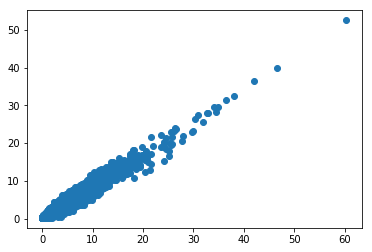

In [256]:
#Gradient Boosting Regression
grad = GradientBoostingRegressor(n_estimators=20,learning_rate=0.1, max_depth=5, random_state=1, loss='ls')
grad.fit(Xout, yout)
plt.scatter(yout,grad.predict(Xout))
r2_score(yout, grad.predict(Xout))

In [257]:
pickle.dump(grad, open('model/grad_1Aug2018.sav', 'wb'))

(0.9358109257896733,
 array([[ 0.00611476,  0.00140333,  0.16714105,  0.00116926,  0.00334007,
          0.15928579, -0.00938544,  0.00080674,  0.25277832,  0.00513721,
         -0.00479777,  0.19649775,  0.00185388,  0.00178009,  0.30368391,
         -0.00502313, -0.00211609,  0.77894144]]))

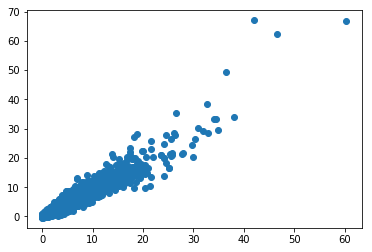

In [246]:
#LinearRegression
slr = LinearRegression()
slr.fit(Xout, yout)
plt.scatter(yout,slr.predict(Xout))
r2_score(yout, slr.predict(Xout)),slr.coef_

In [247]:
pickle.dump(slr, open('model/slr_1Aug2018.sav', 'wb'))

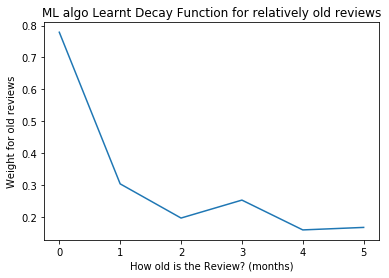

In [258]:
plt.title("ML algo Learnt Decay Function for relatively old reviews")
plt.xlabel('How old is the Review? (months)')
plt.ylabel('Weight for old reviews')
plt.plot(slr.coef_[0][[17,14,11,8,5,2]])

In [261]:
#plt.title("ML algo Learnt weight Function for friends (blue) and review count (orange)")
#plt.xlabel('How old is the Review? (months)')
#plt.ylabel('Weight for old reviews')
#plt.plot(slr.coef_[0][[16,13,10,7,4,1]])
#plt.plot(slr.coef_[0][[15,12,9,6,3,0]])

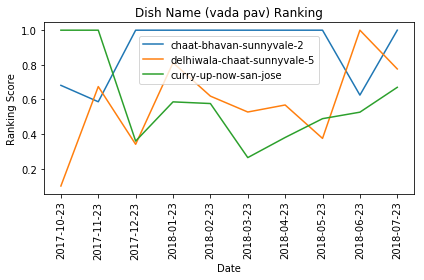

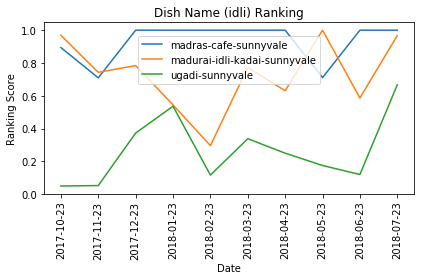

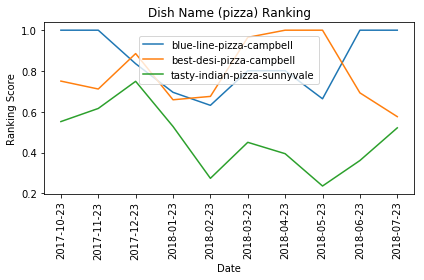

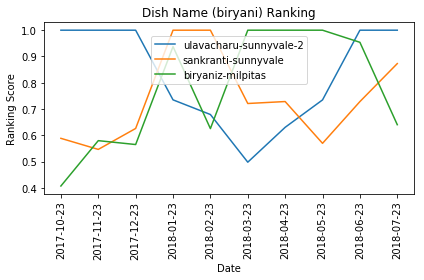

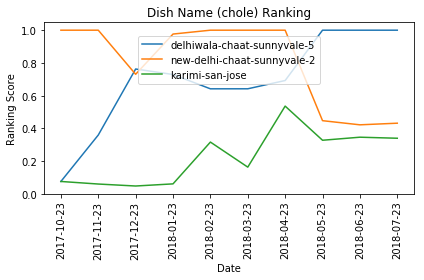

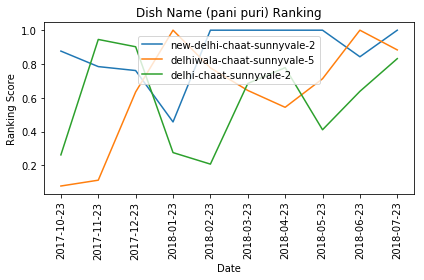

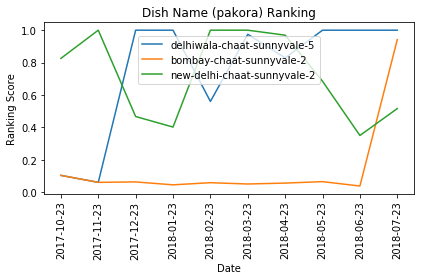

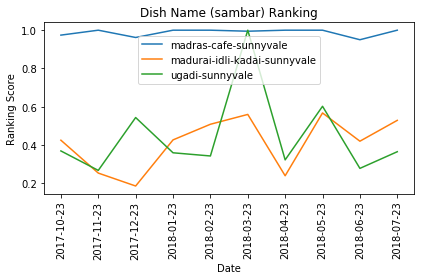

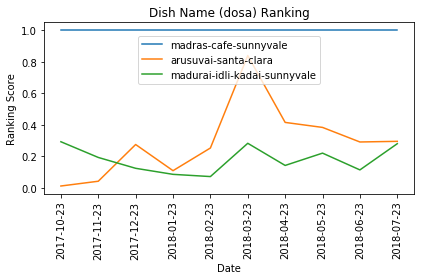

In [284]:
#future prediction plots
for dname in ['vada pav','idli','pizza','biryani','chole','pani puri','pakora','sambar','dosa']:

    dt=['2017-10-23','2017-11-23','2017-12-23','2018-01-23','2018-02-23','2018-03-23','2018-04-23','2018-05-23','2018-06-23','2018-07-23']

    y_pred_list=[]

    for d in dt:
        bd1=big_dataframe.copy()
        del bd1['Unnamed: 0']
        bd2=init_df(bd1,d,dname)
        X=collect_6month_trainset(bd2,d)
        y_pred=grad.predict(X)
        y_pred_list.append(y_pred)


    plt1={}
    for i in range(len(y_pred_list)):
        res_names=np.array(X.index)
        norm_tdidf=np.array(y_pred_list[i]/max(y_pred_list[i]))
        plt1[dt[i]]={}
        for j in range(X.index.size):
            plt1[dt[i]][res_names[j]]=norm_tdidf[j]

    #convert dict to df, and sort it by descending order on tdidf @ latest time.
    #plot top 3 ranked restaurant.
    plt2=pd.DataFrame.from_dict(plt1).sort_values('2018-07-23',ascending=[False])
    x=plt2.columns.tolist()
    fig, ax = plt.subplots()
    for i in range(3):
        y=plt2.ix[i].tolist()
        plt.xticks(rotation=90)
        plt.xlabel('Date')
        plt.ylabel('Ranking Score')
        plt.title('Dish Name ('+dname+') Ranking')
        plt.tight_layout()
        ax.plot(x, y,  label=plt2.index[i])
        leg = ax.legend(loc='upper center',bbox_to_anchor=(0.5, 0.95));
    plt.savefig(dname+'.png', format='png', dpi=300)            

In [286]:
#plt2.head(22)

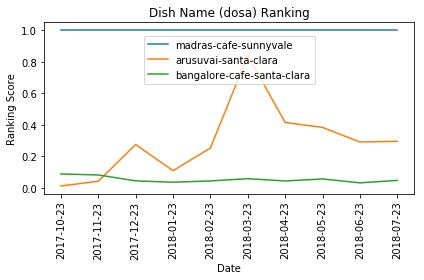

In [283]:
#future prediction plots
for dname in ['dosa']:

    dt=['2017-10-23','2017-11-23','2017-12-23','2018-01-23','2018-02-23','2018-03-23','2018-04-23','2018-05-23','2018-06-23','2018-07-23']

    y_pred_list=[]

    for d in dt:
        bd1=big_dataframe.copy()
        del bd1['Unnamed: 0']
        bd2=init_df(bd1,d,dname)
        X=collect_6month_trainset(bd2,d)
        y_pred=grad.predict(X)
        y_pred_list.append(y_pred)


    plt1={}
    for i in range(len(y_pred_list)):
        res_names=np.array(X.index)
        norm_tdidf=np.array(y_pred_list[i]/max(y_pred_list[i]))
        plt1[dt[i]]={}
        for j in range(X.index.size):
            plt1[dt[i]][res_names[j]]=norm_tdidf[j]

    #convert dict to df, and sort it by descending order on tdidf @ latest time.
    #plot top 3 ranked restaurant.
    plt2=pd.DataFrame.from_dict(plt1).sort_values('2018-07-23',ascending=[False])
    x=plt2.columns.tolist()
    fig, ax = plt.subplots()
    for i in [0,1,22]:
        y=plt2.ix[i].tolist()
        plt.xticks(rotation=90)
        plt.xlabel('Date')
        plt.ylabel('Ranking Score')
        plt.title('Dish Name ('+dname+') Ranking')
        plt.tight_layout()
        ax.plot(x, y,  label=plt2.index[i])
        leg = ax.legend(loc='upper center',bbox_to_anchor=(0.5, 0.95));
    plt.savefig(dname+'.png', format='png', dpi=300)            

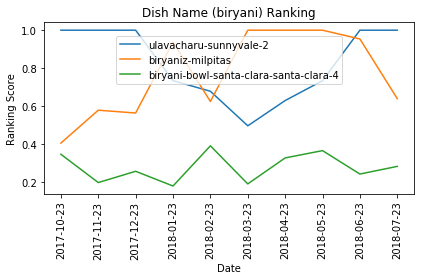

In [287]:
#future prediction plots
for dname in ['biryani']:

    dt=['2017-10-23','2017-11-23','2017-12-23','2018-01-23','2018-02-23','2018-03-23','2018-04-23','2018-05-23','2018-06-23','2018-07-23']

    y_pred_list=[]

    for d in dt:
        bd1=big_dataframe.copy()
        del bd1['Unnamed: 0']
        bd2=init_df(bd1,d,dname)
        X=collect_6month_trainset(bd2,d)
        y_pred=grad.predict(X)
        y_pred_list.append(y_pred)


    plt1={}
    for i in range(len(y_pred_list)):
        res_names=np.array(X.index)
        norm_tdidf=np.array(y_pred_list[i]/max(y_pred_list[i]))
        plt1[dt[i]]={}
        for j in range(X.index.size):
            plt1[dt[i]][res_names[j]]=norm_tdidf[j]

    #convert dict to df, and sort it by descending order on tdidf @ latest time.
    #plot top 3 ranked restaurant.
    plt2=pd.DataFrame.from_dict(plt1).sort_values('2018-07-23',ascending=[False])
    x=plt2.columns.tolist()
    fig, ax = plt.subplots()
    for i in [0,2,9]:
        y=plt2.ix[i].tolist()
        plt.xticks(rotation=90)
        plt.xlabel('Date')
        plt.ylabel('Ranking Score')
        plt.title('Dish Name ('+dname+') Ranking')
        plt.tight_layout()
        ax.plot(x, y,  label=plt2.index[i])
        leg = ax.legend(loc='upper center',bbox_to_anchor=(0.5, 0.95));
    plt.savefig(dname+'.png', format='png', dpi=300)      

In [288]:
#plt2.head(10)

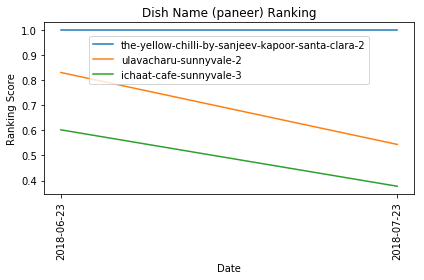

In [291]:
#future prediction plots
for dname in ['paneer']:

    dt=['2018-06-23','2018-07-23']

    y_pred_list=[]

    for d in dt:
        bd1=big_dataframe.copy()
        del bd1['Unnamed: 0']
        bd2=init_df(bd1,d,dname)
        X=collect_6month_trainset(bd2,d)
        y_pred=grad.predict(X)
        y_pred_list.append(y_pred)


    plt1={}
    for i in range(len(y_pred_list)):
        res_names=np.array(X.index)
        norm_tdidf=np.array(y_pred_list[i]/max(y_pred_list[i]))
        plt1[dt[i]]={}
        for j in range(X.index.size):
            plt1[dt[i]][res_names[j]]=norm_tdidf[j]

    #convert dict to df, and sort it by descending order on tdidf @ latest time.
    #plot top 3 ranked restaurant.
    plt2=pd.DataFrame.from_dict(plt1).sort_values('2018-07-23',ascending=[False])
    x=plt2.columns.tolist()
    fig, ax = plt.subplots()
    for i in [0,2,9]:
        y=plt2.ix[i].tolist()
        plt.xticks(rotation=90)
        plt.xlabel('Date')
        plt.ylabel('Ranking Score')
        plt.title('Dish Name ('+dname+') Ranking')
        plt.tight_layout()
        ax.plot(x, y,  label=plt2.index[i])
        leg = ax.legend(loc='upper center',bbox_to_anchor=(0.5, 0.95));
    plt.savefig(dname+'.png', format='png', dpi=300)      